O trabalho 2 é quase que o mesmo que o anterior. O que ele foca é na seleção e remoção de atributos do dataset e o uso de outras métricas para avaliar os modelos.

Para calcular a correlação entre atributos, será utilizado o método do coeficente de relação ($r^2$) entre atributo-saída e atributo-atributo na forma de matriz.

Vamos remover um atributo por vez e conferir se ainda será necessário normalizar os dados.

As métricas serão:
* Acurácia
* Sensibilidade (recall)
* Especificidade (sensibilidade)
* Precisão
* F1-score
* Matriz de confusão

As métricas serão calculadas antes e depois da remoção de atributos.

In [127]:
# Bibliotecas
import numpy as np
import pandas as pd

In [128]:
NUM_ROUNDS = 50

## Definição dos modelos

A distância euclidiana será utilizada nos dois modelos.

In [129]:
def euclidian_distance(x1, x2):
  return np.sqrt(np.sum((x1 - x2) ** 2))

In [130]:
class KNearestNeighbors:
  def __init__(self, n_neighbors=5):
    self.n_neighbors = n_neighbors

  def fit(self, X, y):
    self.X_train = X
    self.y_train = y

  def predict(self, X_test):
    preds = []

    for x_test in X_test:
      distances = [euclidian_distance(x_test, x_train) for x_train in self.X_train]

      k_nearest_indices = np.argsort(distances)[:self.n_neighbors]
      k_nearest_labels = [self.y_train[i] for i in k_nearest_indices]

      unique_labels, counts = np.unique(k_nearest_labels, return_counts=True)
      most_common_label = unique_labels[np.argmax(counts)]

      preds.append(most_common_label)

    return np.array(preds)

class DMC:
  def __init__(self):
    self.centroids = {}
    self.class_counts = {}

  def fit(self, X, y):
    unique_classes = np.unique(y)

    for cls in unique_classes:
      X_class = X[y == cls]
      self.centroids[cls] = np.median(X_class, axis=0)
      self.class_counts[cls] = len(X_class)

    '''
    print('\nCentróides iniciais calculados:')
    for cls, centroid in self.centroids.items():
      print(f'Classe {cls}: centroid')
    '''

  def predict(self, X_test):
    preds = []

    for i, x_test in enumerate(X_test):
      distances = []
      for cls, centroid in self.centroids.items():
        dist = euclidian_distance(x_test, centroid)
        distances.append((dist, cls))
      distances.sort()
      closest_class = distances[0][1]
      preds.append(closest_class)

      # Atualização do centroide
      current_class = self.class_counts[closest_class]
      new_class = current_class + 1
      alpha = 1 / new_class
      self.centroids[closest_class] = (1 - alpha) * self.centroids[closest_class]
      self.class_counts[closest_class] = new_class

      # print(f'Teste {i+1} ({x_test}) foi classificado como {closest_class}')

    return np.array(preds)

# Datasets

Instalando a biblioteca do UCI Datasets para baixar os datasets.

In [131]:
!pip install ucimlrepo --quiet

In [132]:
from ucimlrepo import fetch_ucirepo

In [133]:
def train_test_split(X, y, test_size=0.2, random_state=None):
  if random_state is not None:
      np.random.seed(random_state)

  n_samples = len(X)
  shuffled_indices = np.random.permutation(n_samples)
  n_test_samples = int(n_samples * test_size)
  test_indices = shuffled_indices[:n_test_samples]
  train_indices = shuffled_indices[n_test_samples:]

  X_train, X_test = X[train_indices], X[test_indices]
  y_train, y_test = y[train_indices], y[test_indices]

  return X_train, X_test, y_train, y_test

In [134]:
def label_encoder(data):
  label_to_int = {}
  int_to_label = {}
  encoded = []
  current_label = 0

  for item in data:
      if item not in label_to_int:
          label_to_int[item] = current_label
          int_to_label[current_label] = item
          current_label += 1
      encoded.append(label_to_int[item])

  def inverse_transform(encoded_data):
      return [int_to_label[i] for i in encoded_data]

  return encoded, inverse_transform

# Métricas

In [135]:
def accuracy(y_true, y_pred):
  return np.sum(y_true == y_pred) / len(y_true)

In [136]:
def confusion_matrix(y_true, y_pred, all_classes):
  num_classes = len(all_classes)
  class_to_idx = {cls: i for i, cls in enumerate(all_classes)}

  y_true_mapped = y_true.astype(type(all_classes[0]))
  y_pred_mapped = y_pred.astype(type(all_classes[0]))

  conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

  for true_label, pred_label in zip(y_true_mapped, y_pred_mapped):
      if true_label in class_to_idx and pred_label in class_to_idx:
          true_idx = class_to_idx[true_label]
          pred_idx = class_to_idx[pred_label]
          conf_matrix[true_idx, pred_idx] += 1

  return conf_matrix

In [137]:
def precision(conf_matrix):
  num_classes = conf_matrix.shape[0]
  precisions = []
  for i in range(num_classes):
      TP = conf_matrix[i, i]
      FP = np.sum(conf_matrix[:, i]) - TP
      prec = TP / (TP + FP) if (TP + FP) > 0 else 0.0
      precisions.append(prec)
  return np.mean(precisions)

In [138]:
def recall(conf_matrix):
  num_classes = conf_matrix.shape[0]
  recalls = []
  for i in range(num_classes):
    TP = conf_matrix[i, i]
    FN = np.sum(conf_matrix[i, :]) - TP
    rec = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    recalls.append(rec)
  return np.mean(recalls)

In [139]:
def specificity(conf_matrix):
  num_classes = conf_matrix.shape[0]
  specificities = []
  for i in range(num_classes):
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP
    TN = np.sum(conf_matrix) - (TP + FP + FN)
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0.0
    specificities.append(spec)
  return np.mean(specificities)

In [140]:
def f1_score(conf_matrix):
  num_classes = conf_matrix.shape[0]
  f1s = []
  for i in range(num_classes):
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP

    prec = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    rec = TP / (TP + FN) if (TP + FN) > 0 else 0.0

    f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0
    f1s.append(f1)
  return np.mean(f1s)

# Função genérica

O código é muito repetitivo, mas como nossos modelos foram implementados de forma parecida, conseguimos criar uma função genérica para lidar com todos os casos.

In [254]:
def evaluate_and_get_metrics(X, y, class_labels):
  print("Dimensão dos dados de entrada:", X.shape)

  num_classes = len(class_labels)
  metrics_results = {
    "knn3": {"acc": [], "recall": [], "precision": [], "specificity": [],
              "f1": [], "conf_matrix": np.zeros((num_classes, num_classes))},
    "knn5": {"acc": [], "recall": [], "precision": [], "specificity": [],
              "f1": [], "conf_matrix": np.zeros((num_classes, num_classes))},
    "dmc":  {"acc": [], "recall": [], "precision": [], "specificity": [],
              "f1": [], "conf_matrix": np.zeros((num_classes, num_classes))},
  }
  models = {
      "knn3": KNearestNeighbors(n_neighbors=3),
      "knn5": KNearestNeighbors(n_neighbors=5),
      "dmc": DMC()
  }

  for i in range(NUM_ROUNDS):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    for label, model in models.items():
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

      acc = accuracy(y_test, y_pred)
      cm = confusion_matrix(y_test, y_pred, class_labels)

      rec = recall(cm)
      prec = precision(cm)
      spec = specificity(cm)
      f1 = f1_score(cm)

      metrics_results[label]["acc"].append(acc)
      metrics_results[label]["recall"].append(rec)
      metrics_results[label]["precision"].append(prec)
      metrics_results[label]["specificity"].append(spec)
      metrics_results[label]["f1"].append(f1)
      metrics_results[label]["conf_matrix"] += cm

  summary_table = {}
  conf_matrices = {}
  model_names = {'knn3': 'KNN (k=3)', 'knn5': 'KNN (k=5)', 'dmc': 'DMC'}

  for model_label, values in metrics_results.items():
    name = model_names[model_label]
    summary_table[name] = {
      'Acurácia': f'{np.mean(values["acc"]):.4f} ± {np.std(values["acc"]):.4f}',
      'Recall (Macro)': f'{np.mean(values["recall"]):.4f}',
      'Precisão (Macro)': f'{np.mean(values["precision"]):.4f}',
      'Especificidade (Macro)': f'{np.mean(values["specificity"]):.4f}',
      'F1-Score (Macro)': f'{np.mean(values["f1"]):.4f}'
    }
    conf_matrices[name] = values['conf_matrix'] // 10

  return pd.DataFrame.from_dict(summary_table, orient='index'), conf_matrices

# Teste com o Iris

Download do dataset

In [255]:
iris = fetch_ucirepo(id=53)

X = iris.data.features
y = iris.data.targets.values.ravel()

iris_class_labels = np.unique(y)
iris_class_names = [name.replace('Iris-', '') for name in iris_class_labels]

num_classes = len(iris_class_labels)

## Antes da seleção de atributos

In [256]:
iris_metrics_og, iris_conf_matrices_og = evaluate_and_get_metrics(X.values, y, iris_class_labels)

Dimensão dos dados de entrada: (150, 4)


## Seleção de atributos

Atributo-atributo

In [257]:
X.corr()

,sepal length,sepal width,petal length,petal width
sepal length,1.000000,-0.109369,0.871754,0.817954
sepal width,-0.109369,1.000000,-0.420516,-0.356544
petal length,0.871754,-0.420516,1.000000,0.962757
petal width,0.817954,-0.356544,0.962757,1.000000


Atributo-saída

In [258]:
y_encod, _ = label_encoder(iris.data.targets['class'])

X.corrwith(pd.Series(y_encod, name='Target'))

,0
sepal length,0.782561
sepal width,-0.419446
petal length,0.949043
petal width,0.956464


Remoção de atributos

In [259]:
REMOVE_COLUMNS = ['sepal width', 'petal width']

X_reduced = X.drop(columns=REMOVE_COLUMNS)

## Depois da seleção de atributos

In [260]:
iris_metrics_alt, iris_conf_matrices_alt = evaluate_and_get_metrics(X_reduced.values, y, iris_class_labels)

Dimensão dos dados de entrada: (150, 2)


# Teste com dermatology

In [261]:
dermatology = fetch_ucirepo(id=33)

X = dermatology.data.features
y = dermatology.data.targets.values.ravel()

dermatology_class_labels = np.unique(y)
dermatology_class_names = [
    'psoriasis', 'seboreic dermatitis', 'lichen planus',
    'pityriasis rosea', 'cronic dermatitis', 'pityriasis rubra pilaris'
]

Normalização do dataset e tratamento de NaN

In [262]:
X.loc[:, 'age'] = X['age'].fillna(X['age'].mean())

A atividade propõe remover atributos para conferir se o desempenho não só não piora como também acaba com a necessidade de normalização de dados.

In [263]:
# X = (X - X.min()) / (X.max() - X.min())

## Antes da seleção de atributos

In [264]:
dermatology_metrics_og, dermatology_conf_matrices_og = evaluate_and_get_metrics(X.values, y, dermatology_class_labels)

Dimensão dos dados de entrada: (366, 34)


## Seleção de atributos

In [265]:
X.corr()

,erythema,scaling,definite-borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral-mucosal involvement,knee elbow involvement,scalp involvement,...,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of the basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear infiltrate,band-like infiltrate,age
erythema,1.000000,0.435467,0.260087,-0.047623,0.000694,0.033571,-0.109550,-0.026810,0.141008,0.186684,...,-0.013761,0.159100,0.002559,0.022468,-0.005779,-0.005450,0.009539,0.075758,-0.006955,-0.004974
scaling,0.435467,1.000000,0.357987,-0.084197,-0.010576,-0.075035,-0.092400,-0.082969,0.298398,0.301577,...,-0.085021,0.211484,-0.109523,0.012151,-0.114467,-0.010518,-0.011135,-0.010977,-0.132079,0.015830
definite-borders,0.260087,0.357987,1.000000,-0.062564,0.241342,0.327754,-0.166662,0.286684,0.302309,0.268862,...,0.291147,0.354768,0.298095,-0.255536,0.274576,-0.086250,-0.123947,0.111882,0.282578,0.135968
itching,-0.047623,-0.084197,-0.062564,1.000000,0.267878,0.409696,-0.144825,0.359163,-0.299645,-0.155639,...,0.363488,-0.192684,0.367650,0.017514,0.376186,-0.175866,-0.184074,0.062781,0.386691,0.047388
koebner phenomenon,0.000694,-0.010576,0.241342,0.267878,1.000000,0.394108,-0.172741,0.392554,-0.066372,0.015202,...,0.400409,0.004327,0.376473,-0.005938,0.381687,-0.147955,-0.164364,0.083358,0.382844,0.080329
polygonal papules,0.033571,-0.075035,0.327754,0.409696,0.394108,1.000000,-0.137093,0.865142,-0.276058,-0.253234,...,0.880972,-0.119698,0.911626,0.080063,0.895107,-0.095477,-0.110204,0.228426,0.905822,0.095799
follicular papules,-0.109550,-0.092400,-0.166662,-0.144825,-0.172741,-0.137093,1.000000,-0.132394,0.222255,-0.003535,...,-0.118710,-0.157296,-0.139960,-0.013454,-0.139141,0.785282,0.844929,-0.084864,-0.133871,-0.371012
oral-mucosal involvement,-0.026810,-0.082969,0.286684,0.359163,0.392554,0.865142,-0.132394,1.000000,-0.283466,-0.259813,...,0.884351,-0.106704,0.887552,0.120344,0.875209,-0.082601,-0.106426,0.250937,0.892341,0.110250
knee elbow involvement,0.141008,0.298398,0.302309,-0.299645,-0.066372,-0.276058,0.222255,-0.283466,1.000000,0.659206,...,-0.267508,0.481743,-0.282151,-0.413200,-0.280395,0.232903,0.257661,-0.068621,-0.276711,-0.077980
scalp involvement,0.186684,0.301577,0.268862,-0.155639,0.015202,-0.253234,-0.003535,-0.259813,0.659206,1.000000,...,-0.255554,0.488804,-0.252483,-0.420718,-0.257210,-0.051894,-0.017352,0.035152,-0.249975,0.036277


In [266]:
X.corrwith(dermatology.data.targets['class'])

,0
erythema,-0.335537
scaling,-0.468688
definite-borders,-0.391974
itching,0.054772
koebner phenomenon,-0.091323
polygonal papules,0.057785
follicular papules,0.477813
oral-mucosal involvement,0.055805
knee elbow involvement,-0.383305
scalp involvement,-0.533208


In [267]:
REMOVE_COLUMNS = ['age', 'band-like infiltrate', 'focal hypergranulosis',
                  'hyperkeratosis', 'eosinophils in the infiltrate',
                  'koebner phenomenon']

X_reduced = X.drop(columns=REMOVE_COLUMNS)

## Depois da seleção de atributos

In [268]:
dermatology_metrics_alt, dermatology_conf_matrices_alt = evaluate_and_get_metrics(X_reduced.values, y, dermatology_class_labels)

Dimensão dos dados de entrada: (366, 28)


# Resultados

In [269]:
import matplotlib.pyplot as plt
import seaborn as sn

## Tabelas

In [278]:
print("Dataset: Iris\n")
print("Antes da remoção de atributos:\n")
display(iris_metrics_og)
print("\nDepois da Remoção de atributos:\n")
display(iris_metrics_alt)

Dataset: Iris

Antes da remoção de atributos:



,Acurácia,Recall (Macro),Precisão (Macro),Especificidade (Macro),F1-Score (Macro)
KNN (k=3),0.9613 ± 0.0293,0.9621,0.9637,0.9804,0.9609
KNN (k=5),0.9613 ± 0.0315,0.9616,0.9641,0.9803,0.9606
DMC,0.8647 ± 0.0651,0.8702,0.8859,0.9340,0.8594



Depois da Remoção de atributos:



,Acurácia,Recall (Macro),Precisão (Macro),Especificidade (Macro),F1-Score (Macro)
KNN (k=3),0.9473 ± 0.0299,0.9452,0.9506,0.9733,0.9448
KNN (k=5),0.9460 ± 0.0339,0.9448,0.9492,0.9726,0.9439
DMC,0.8507 ± 0.0690,0.8562,0.8728,0.9269,0.8445


In [289]:
print("Dataset: Dermatology\n")
print("Antes da remoção de atributos:\n")
display(dermatology_metrics_og)
print("\nDepois da remoção de atributos:\n")
display(dermatology_metrics_alt)

Dataset: Dermatology

Antes da remoção de atributos:



,Acurácia,Recall (Macro),Precisão (Macro),Especificidade (Macro),F1-Score (Macro)
KNN (k=3),0.8808 ± 0.0361,0.8672,0.8568,0.9767,0.8545
KNN (k=5),0.8633 ± 0.0420,0.8484,0.8383,0.9734,0.8334
DMC,0.5510 ± 0.0520,0.5624,0.5494,0.9104,0.5185



Depois da remoção de atributos:



,Acurácia,Recall (Macro),Precisão (Macro),Especificidade (Macro),F1-Score (Macro)
KNN (k=3),0.9532 ± 0.0207,0.9494,0.9493,0.9910,0.9445
KNN (k=5),0.9540 ± 0.0224,0.9510,0.9498,0.9912,0.9456
DMC,0.9293 ± 0.0283,0.9200,0.9225,0.9862,0.9178


## Matrizes de confusão

In [286]:
def plot_confusion_matrices(matrices_before, matrices_after, class_names, dataset_name):
  model_names = list(matrices_before.keys())
  fig, axes = plt.subplots(len(model_names), 2, figsize=(10, 5 * len(model_names)))
  fig.suptitle(f'Matrizes de Confusão Médias - {dataset_name}', fontsize=16, y=1.02)

  for i, model in enumerate(model_names):
    sn.heatmap(matrices_before[model], annot=True, fmt=".0f", cmap='Blues', ax=axes[i, 0],
              xticklabels=class_names, yticklabels=class_names, cbar=False)
    axes[i, 0].set_title(f'{model} (Antes da Remoção)')
    axes[i, 0].set_xlabel('Predito')
    axes[i, 0].set_ylabel('Verdadeiro')
    sn.heatmap(matrices_after[model], annot=True, fmt=".0f", cmap='Greens', ax=axes[i, 1],
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    axes[i, 1].set_title(f'{model} (Depois da Remoção)')
    axes[i, 1].set_xlabel('Predito')
    axes[i, 1].set_ylabel('Verdadeiro')

  plt.tight_layout(rect=[0, 0, 1, 0.98])
  plt.show()


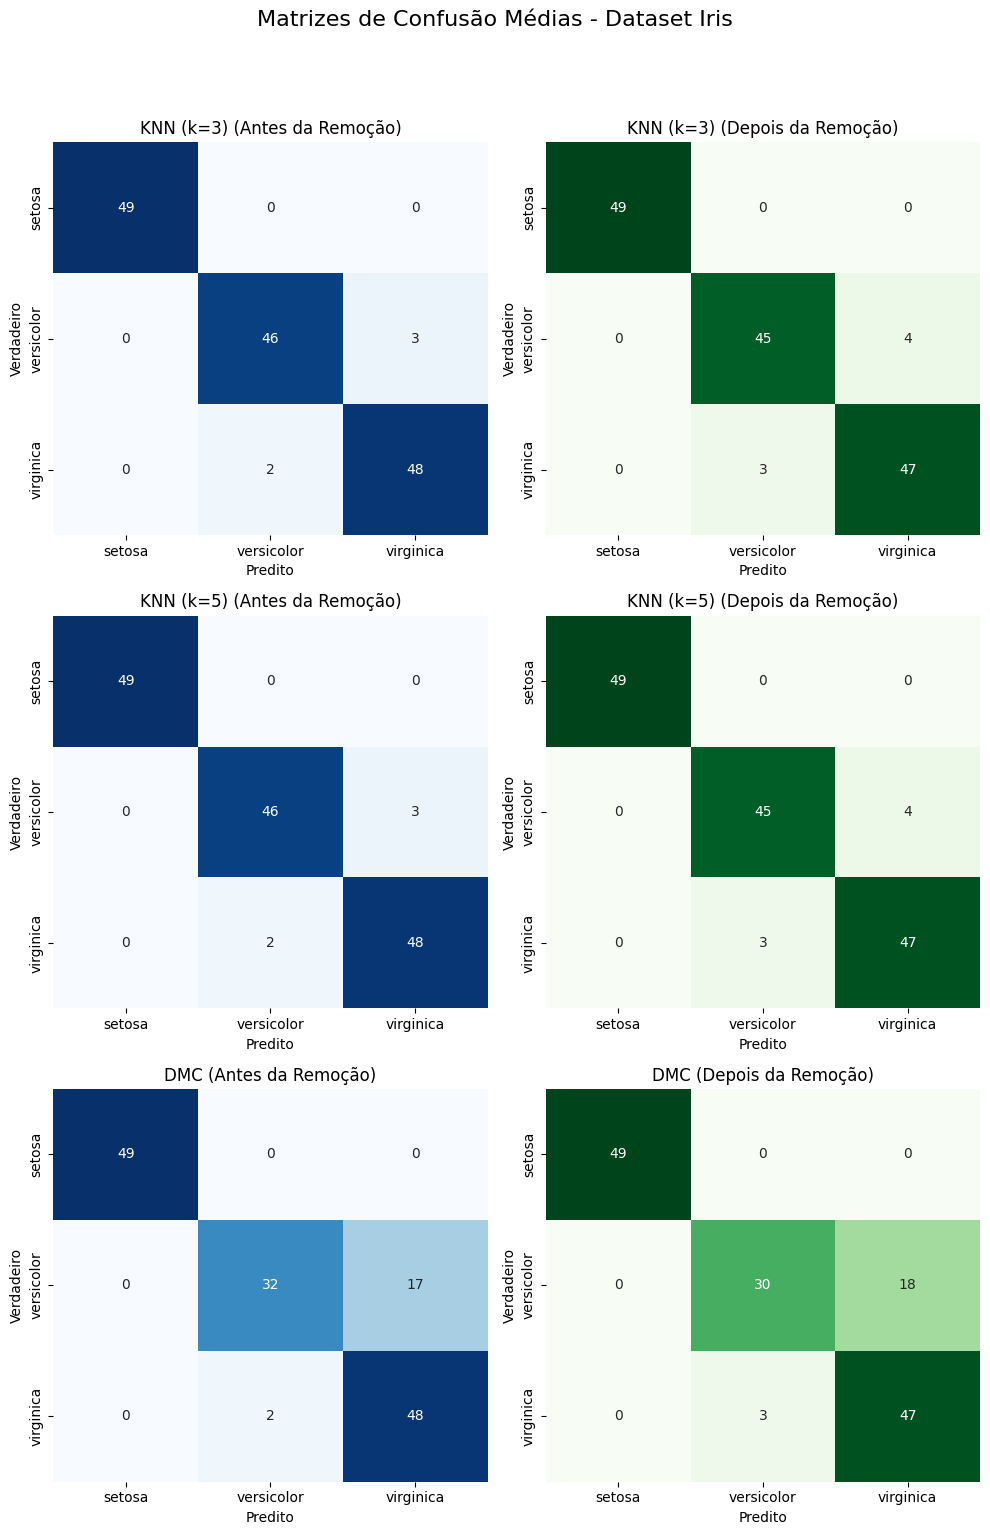

In [287]:
plot_confusion_matrices(iris_conf_matrices_og, iris_conf_matrices_alt, iris_class_names, "Dataset Iris")

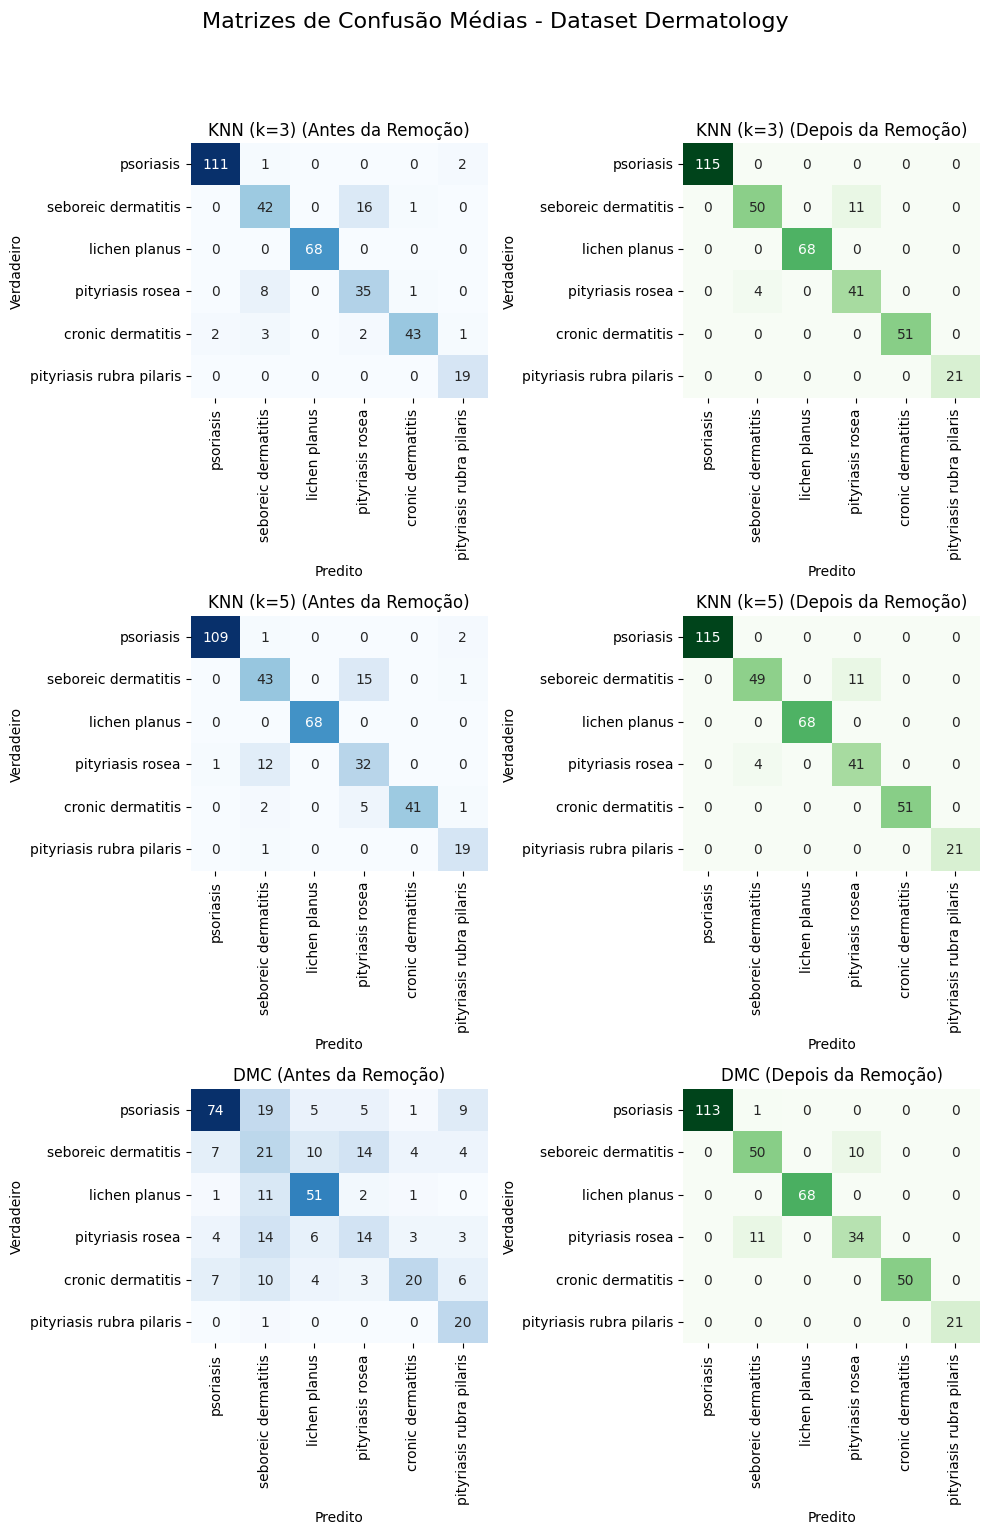

In [288]:
plot_confusion_matrices(dermatology_conf_matrices_og, dermatology_conf_matrices_alt, dermatology_class_names, "Dataset Dermatology")